# Подготовка сессии

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.utils import draw_segmentation_masks

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

import json

In [ ]:
!pip install -U --no-cache-dir gdown --pre
!gdown 1IH84zerloTZGNF33Kbj1-5IoGTNFAolR
!gdown 1MXZT_Pmxm6e1L0NLRRBf5D9NayDaiT5a
!gdown 1JT8BxW0q4YXJeCFmjzwEH0lkICgY1Qko

In [ ]:
!mkdir train
!unzip train_dataset_mc.zip -d train
!unzip test_dataset_mc2.zip

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [2]:
class EyeDataset(Dataset):
    """
    Класс датасета, организующий загрузку и получение изображений и соответствующих разметок
    """

    def __init__(self, data_folder: str, transform = None):
        self.class_ids = {"vessel": 1}

        self.data_folder = data_folder
        self.transform = transform
        self._image_files = glob.glob(f"{data_folder}/*.png")

        self._image_files = [i for i in self._image_files if glob.glob(i.replace("png", "geojson"))]

        with open("image_files.txt") as f:
            files = f.read()
        files = files.split(', ')

        self._image_files = ['/content/train/' + file for file in files]
        

    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image / 255, dtype=np.float32)
        return image

    @staticmethod 
    def parse_polygon(coordinates, image_size): 
        mask = np.zeros(image_size, dtype=np.int32) 
    
        if len(coordinates) == 1: 
            points = [np.int32(coordinates)] 
            cv2.fillPoly(mask, points, 1) 
        else: 
            points = [np.int32([coordinates[0]])] 
            cv2.fillPoly(mask, points, 1) 
    
            for polygon in coordinates[1:]:
                points = [np.int32([polygon])] 
                cv2.fillPoly(mask, points, 0)
        return mask

    @staticmethod
    def parse_mask(shape: dict, image_size: tuple) -> np.ndarray:
        """
        Метод для парсинга фигур из geojson файла
        """
        mask = np.zeros(image_size, dtype=np.int32)
        coordinates = shape['coordinates']
        if shape['type'] == 'MultiPolygon':
            for polygon in coordinates:
                mask |= EyeDataset.parse_polygon(polygon, image_size)
        else:
            mask |= EyeDataset.parse_polygon(coordinates, image_size)
        # print(np.unique(mask))
        return mask

    def read_layout(self, path: str, image_size: tuple) -> np.ndarray:
        """
        Метод для чтения geojson разметки и перевода в numpy маску
        """
        with open(path, 'r', encoding='cp1251') as f:  # some files contain cyrillic letters, thus cp1251
            json_contents = json.load(f)

        num_channels = 1 + max(self.class_ids.values())
        mask_channels = [np.zeros(image_size, dtype=np.float32) for _ in range(num_channels)]
        mask = np.zeros(image_size, dtype=np.float32)

        if type(json_contents) == dict and json_contents['type'] == 'FeatureCollection':
            features = json_contents['features']
        elif type(json_contents) == list:
            features = json_contents
        else:
            features = [json_contents]

        for shape in features:
            channel_id = self.class_ids["vessel"]
            mask = self.parse_mask(shape['geometry'], image_size)
            mask_channels[channel_id] = np.maximum(mask_channels[channel_id], mask)

        mask_channels[0] = 1 - np.max(mask_channels[1:], axis=0)

        return np.stack(mask_channels, axis=-1)

    def __getitem__(self, idx: int) -> dict:
        # Достаём имя файла по индексу
        image_path = self._image_files[idx]

        # Получаем соответствующий файл разметки
        json_path = image_path.replace("png", "geojson")

        image = self.read_image(image_path)

        mask = self.read_layout(json_path, image.shape[:2])

        sample = {'image': image,
                  'mask': mask}

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self):
        return len(self._image_files)

    # Метод для проверки состояния датасета
    def make_report(self):
      reports = []
      if (not self.data_folder):
        reports.append("Путь к датасету не указан")
      if (len(self._image_files) == 0):
        reports.append("Изображения для распознавания не найдены")
      else:
        reports.append(f"Найдено {len(self._image_files)} изображений")
      cnt_images_without_masks = sum([1 - len(glob.glob(filepath.replace("png", "geojson"))) for filepath in self._image_files])
      if cnt_images_without_masks > 0:
        reports.append(f"Найдено {cnt_images_without_masks} изображений без разметки")
      else:
        reports.append(f"Для всех изображений есть файл разметки")
      return reports


class DatasetPart(Dataset):
    """
    Обертка над классом датасета для его разбиения на части
    """
    def __init__(self, dataset: Dataset,
                 indices: np.ndarray,
                 transform: A.Compose = None):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> dict:
        sample = self.dataset[self.indices[idx]]

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self) -> int:
        return len(self.indices)

In [3]:
# Задаем преобразование изображений
size = 1600
train_list = [A.LongestMaxSize(size),
              A.PadIfNeeded(size, size),
              ToTensorV2(transpose_mask=True),
              ]
eval_list = [A.LongestMaxSize(size),
             A.PadIfNeeded(size, size),
             ToTensorV2(transpose_mask=True),
             ]

transforms = {'train': A.Compose(train_list), 'test': A.Compose(eval_list)}


In [4]:
# Инициализируем датасет
dataset = EyeDataset("/content/train")

In [5]:
# Проверим состояние загруженного датасета
for msg in dataset.make_report():
  print(msg)

Найдено 542 изображений
Для всех изображений есть файл разметки


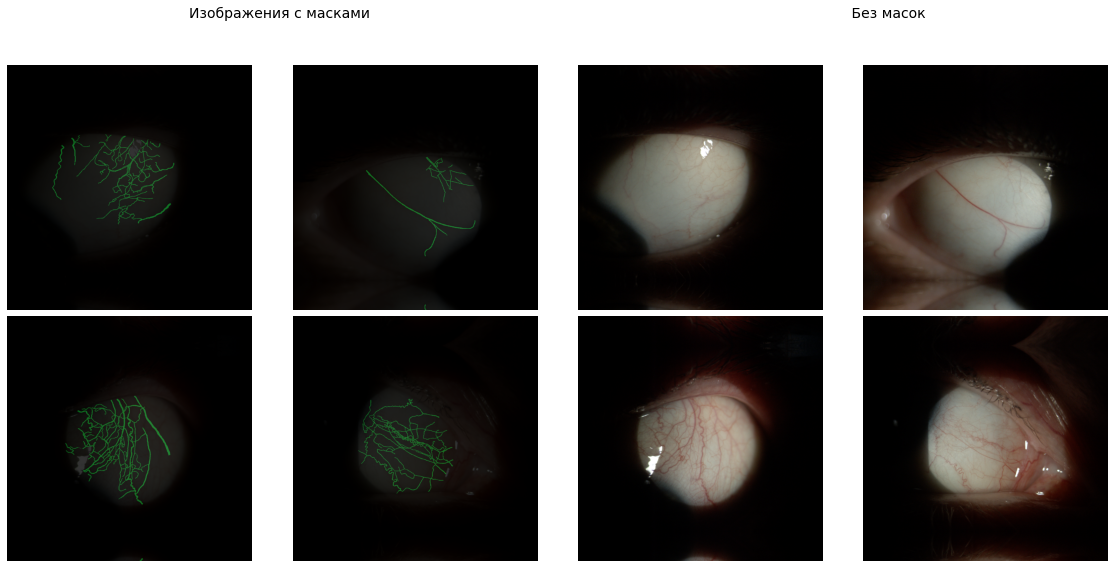

In [6]:
# Посмотрим на картинки из датасета

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Изображения с масками {" "*105} Без масок', fontsize=14)

for i, sample in zip(range(4), dataset):
    transformed = transforms['test'](**sample)
    image, mask = transformed["image"], transformed["mask"]

    image_with_mask = draw_segmentation_masks((image.cpu() * 255).type(torch.uint8), mask.type(torch.bool))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')

    image = np.moveaxis(image.cpu().numpy(), 0, -1)    
    axs[i // 2, (i % 2)+2].imshow(image)
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [ ]:
from os import listdir

print("Обучающей выборки ", len(listdir("/content/train")) // 2)
print("Тестовой выборки ", len(listdir("/content/eye_test")))

In [8]:
# разделим датасет на тренировочный и валидационный, чтобы смотреть на качество
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.1)

In [ ]:
print(f"Разбиение на train/test : {len(train_indices)}/{len(test_indices)}")

In [10]:
# Разбиваем объект датасета на тренировачный и валидационный
train_dataset = DatasetPart(dataset, train_indices, transform=transforms['train'])
valid_dataset = DatasetPart(dataset, test_indices, transform=transforms['test'])

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, 1,
                                           num_workers=4,
                                   shuffle=True, drop_last=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 1,
                                           num_workers=4,
                                   shuffle=True, drop_last=True)

## Вспомогательные функции

In [12]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

# Класс тренировщика модели

In [18]:
from typing import Tuple, List, Callable, Iterator, Optional, Dict, Any
from collections import defaultdict

class UnetTrainer:
    """
    Класс, реализующий обучение модели
    """

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                 criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor], scaler,
                 device: str, metric_functions: List[Tuple[str, Callable]] = [],
                 epoch_number: int = 0,
                 lr_scheduler: Optional[Any] = None):
        self.model = model
        self.optimizer = optimizer
        self.scaler = scaler
        self.criterion = criterion
        self.lr_scheduler = lr_scheduler

        self.device = device

        self.metric_functions = metric_functions

        self.epoch_number = epoch_number

    @torch.no_grad()
    def evaluate_batch(self, val_iterator: Iterator, eval_on_n_batches: int) -> Optional[Dict[str, float]]:     
        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(eval_on_n_batches):
            try:
                batch = next(val_iterator)

                xs = batch['image'].to(self.device)
                ys_true = batch['mask'].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break
            ys_pred = self.model.eval()(xs)
            loss = self.criterion(ys_pred, ys_true)

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets)

        return metrics

    @torch.no_grad()
    def evaluate(self, val_loader, eval_on_n_batches: int = 1) -> Dict[str, float]:
        """
        Вычисление метрик для эпохи
        """
        metrics_sum = defaultdict(float)
        num_batches = 0

        val_iterator = iter(val_loader)

        while True:
            batch_metrics = self.evaluate_batch(val_iterator, eval_on_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit_batch(self, train_iterator: Iterator, update_every_n_batches: int) -> Optional[Dict[str, float]]:
        """
        Тренировка модели на одном батче
        """

        self.optimizer.zero_grad()

        predictions = []
        targets = []

        losses = []

        self.model.train()

        for real_batch_number in range(update_every_n_batches):
            try:
                batch = next(train_iterator)

                xs = batch['image'].to(self.device)
                ys_true = batch['mask'].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break
            with torch.autocast(device_type='cuda'):
                ys_pred = self.model(xs)
                loss = self.criterion(ys_pred, ys_true)

            self.scaler.scale(loss).backward()
            # (loss / update_every_n_batches).backward()

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        self.scaler.step(self.optimizer)
        # self.optimizer.step()
        self.scaler.update()
        self.optimizer.zero_grad()

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets)

        return metrics

    def fit_epoch(self, train_loader, update_every_n_batches: int = 1) -> Dict[str, float]:
        """
        Одна эпоха тренировки модели
        """

        metrics_sum = defaultdict(float)
        num_batches = 0

        train_iterator = iter(train_loader)

        while True:
            batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit(self, train_loader, num_epochs: int,
            val_loader = None, update_every_n_batches: int = 1,
            ) -> Dict[str, np.ndarray]:
        """
        Метод, тренирующий модель и вычисляющий метрики для каждой эпохи
        """

        summary = defaultdict(list)

        def save_metrics(metrics: Dict[str, float], postfix: str = '') -> None:
          # Сохранение метрик в summary
            nonlocal summary, self

            for metric in metrics:
                metric_name, metric_value = f'{metric}{postfix}', metrics[metric]

                summary[metric_name].append(metric_value)

        for _ in tqdm(range(num_epochs - self.epoch_number), initial=self.epoch_number, total=num_epochs):
            self.epoch_number += 1

            train_metrics = self.fit_epoch(train_loader, update_every_n_batches)

            with torch.no_grad():
                save_metrics(train_metrics, postfix='_train')

                if val_loader is not None:
                    test_metrics = self.evaluate(val_loader)
                    save_metrics(test_metrics, postfix='_test')

            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

            torch.save(self.model.state_dict(), f'final_4_{self.epoch_number}.pt')
            print(train_metrics, test_metrics)

        summary = {metric: np.array(summary[metric]) for metric in summary}

        return summary


# Метрики

In [19]:
# F1-мера
class SoftDice:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = 2 * torch.sum(predictions * targets)
        denominator = torch.sum(predictions + targets)
        return (numerator + self.epsilon) / (denominator + self.epsilon)

# Метрика полноты
class Recall:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = torch.sum(predictions * targets)
        denominator = torch.sum(targets)

        return numerator / (denominator + self.epsilon)

# Метрика точности
class Accuracy:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: list, targets: list) -> torch.Tensor:
        numerator = torch.sum(predictions * targets)
        denominator = torch.sum(predictions)

        return numerator / (denominator + self.epsilon)

def make_metrics():
    soft_dice = SoftDice()
    recall = Recall()
    accuracy = Accuracy()

    def exp_dice(pred, target):
        return np.array([soft_dice(torch.exp(pred[:, 1:]) > i / 10, target[:, 1:]) for i in range(1, 10)])

    def exp_accuracy(pred, target):
        return accuracy(torch.exp(pred[:, 1:]) > 0.5, target[:, 1:])
        # return soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    def exp_recall(pred, target):
        return recall(torch.exp(pred[:, 1:]) > 0.5, target[:, 1:])

    return [('dice', exp_dice),
            ('accuracy', exp_accuracy),
            ('recall', exp_recall),
            ]

## Модель

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
torch.cuda.empty_cache()

In [22]:
model = smp.UnetPlusPlus('resnext50_32x4d', activation='logsoftmax', classes=2, encoder_weights='swsl').cuda()

def make_criterion():
    soft_dice = SoftDice()

    def exp_dice(pred, target):
        return 1 - soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    return exp_dice

criterion = make_criterion()

In [23]:
import math
import torch
import torch.optim

from typing import TYPE_CHECKING, Any, Callable, Optional

if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any

class MADGRAD(torch.optim.Optimizer):
    """
    MADGRAD_: A Momentumized, Adaptive, Dual Averaged Gradient Method for Stochastic 
    Optimization.
    .. _MADGRAD: https://arxiv.org/abs/2101.11075
    MADGRAD is a general purpose optimizer that can be used in place of SGD or
    Adam may converge faster and generalize better. Currently GPU-only.
    Typically, the same learning rate schedule that is used for SGD or Adam may
    be used. The overall learning rate is not comparable to either method and
    should be determined by a hyper-parameter sweep.
    MADGRAD requires less weight decay than other methods, often as little as
    zero. Momentum values used for SGD or Adam's beta1 should work here also.
    On sparse problems both weight_decay and momentum should be set to 0.
    Arguments:
        params (iterable): 
            Iterable of parameters to optimize or dicts defining parameter groups.
        lr (float): 
            Learning rate (default: 1e-2).
        momentum (float): 
            Momentum value in the range [0,1) (default: 0.9).
        weight_decay (float): 
            Weight decay, i.e. a L2 penalty (default: 0).
        eps (float): 
            Term added to the denominator outside of the root operation to improve 
            numerical stability. (default: 1e-6).
            This parameter is less important in MADGRAD than in Adam. 
            On problems with very small gradients, setting this to 0 will improve convergence.
        decouple_decay (bool):
            Apply AdamW style decoupled weight decay (EXPERIMENTAL).
    """

    def __init__(
        self, params: _params_t, lr: float = 1e-2, momentum: float = 0.9, 
        weight_decay: float = 0, eps: float = 1e-6, decouple_decay=False,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1)")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, 
                        weight_decay=weight_decay, decouple_decay=decouple_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        # step counter must be stored in state to ensure correct behavior under
        # optimizer sharding
        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]
            decouple_decay = group["decouple_decay"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0 and not decouple_decay:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    if eps == 0:
                        rms_masked_vals[rms_masked_vals == 0] = float('inf')

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    if eps == 0:
                        rms[rms == 0] = float('inf')

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    if decay != 0 and decouple_decay:
                        p_old = p.data.clone()

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)
                    
                    if decay != 0 and decouple_decay:
                        p.data.add_(p_old, alpha=-lr*decay)


        self.state['k'] += 1
        return loss

In [24]:
optimizer = MADGRAD(model.parameters(), 1e-5)

In [25]:
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-8, last_epoch=- 1, verbose=False)

In [26]:
from torch.cuda.amp import GradScaler

scaler = GradScaler()

In [ ]:
# Обучаем модель
trainer = UnetTrainer(model, optimizer, criterion, scaler, 'cuda', metric_functions=make_metrics(), lr_scheduler=lr_scheduler)
summary = trainer.fit(train_loader, 10, val_loader=valid_loader)

## Посмотрим метрики обученной модели на валидационном датасете

In [ ]:
summary

In [ ]:
# Функция потерь
plot_history(summary['loss_train'], summary['loss_test'])

In [ ]:
# Точность
plot_history(summary['accuracy_train'], summary['accuracy_test'], "accuracy")

In [ ]:
# Полнота
plot_history(summary['recall_train'], summary['recall_test'], "recall")

In [ ]:
# Посмотрим на картинки предсказаний

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Предскзаания модели {" "*105} Эталонная разметка', fontsize=14)

for i, sample in zip(range(4), valid_dataset):
    image = sample['image'].to("cuda")
    true_mask = sample['mask'].to("cuda")

    prediction = model.eval()(image.unsqueeze(dim=0))

    image = (image.cpu() * 255).type(torch.uint8)
    pred_ask = (torch.exp(prediction[0]) > 0.5).cpu()

    image_with_mask = draw_segmentation_masks(image, pred_ask)
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')


    image_with_mask = draw_segmentation_masks(image, true_mask.type(torch.bool))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)
    axs[i // 2, (i % 2)+2].imshow(image_with_mask)
    axs[i // 2, (i % 2)+2].axis('off')


fig.tight_layout()
fig.subplots_adjust(top=0.88)